#LangChain vs LangGraph Notes

Overview

>LangChain and LangGraph are two powerful libraries for building LLM-powered applications, but they serve different needs and architectural patterns. LangChain is more functionally and chain-based, while LangGraph introduces graph-based node execution that is ideal for complex, stateful, and dynamic workflows.

#🔁 Challenge #1: Control Flow Complexity

Key Aspects:

>Conditional Branching

>Loops

>Jumps

Problem in LangChain:

>LangChain is primarily linear. Complex control flow like if/else, loops, retries, and conditional node jumps require you to manually write "glue code" using Python logic outside LangChain. This introduces spaghetti logic and makes the pipeline harder to maintain and test.

Why glue code is bad:

>Logic is scattered between LangChain and raw Python

>Harder to debug and trace

>Reusability and modularity are low

>Maintenance becomes difficult as workflows grow in complexity

How these problems appear in LangChain:

>Conditional Branch: You must write Python if statements outside the chain.

>Loops: Require manual while loops or recursion around chains.

>Jumps: Impossible to skip nodes conditionally inside a sequential chain.

LangGraph Advantage:

LangGraph offers native support for control flow with its node-based architecture using StateGraph. It allows:

>if/else branching directly in the graph

>Loops using graph.add_conditional_edges

>Jumps and state-based redirection

>Removes the need for glue code entirely; logic stays inside graph structure

```
graph.add_node("HiringRequest", hiring_request)
graph.add_node("CreateJD", create_jd)
graph.add_node("CheckApproval", check_approval)
graph.add_node("PostJD", post_jd)

graph.add_edge("HiringRequest", "CreateJD")
graph.add_edge("CreateJD", "CheckApproval")

graph.add_conditional_edges(
    "CheckApproval",
    approval_router,
    {
        "approved": "PostJD",
        "not_approved": "CreateJD" # 🔄 Loop back
    }
)

graph.add_edge("PostJD", END)
```

```
def hiring_request(_: JDState) -> JDState:
    return {"prompt": "We need to hire a software engineer for the backend team"}


llm = ChatOpenAI(model="gpt-4", temperature=0)


def create_jd(state: JDState) -> JDState:
    prompt = state["prompt"]
    response = llm.invoke(f"Create a job description for this: {prompt}")
    return {**state, "jd": response.content}


def check_approval(state: JDState) -> JDState:
    jd_text = state["jd"]
    approved = "engineer" in jd_text.lower()  # dummy logic
    return {**state, "approved": approved}


def approval_router(state: JDState) -> Literal["approved", "not_approved"]:
    return "approved" if state["approved"] else "not_approved"


def post_jd(state: JDState) -> JDState:
    print(f"\n✅ Final Approved JD:\n")
    print(state["jd"])
    return state

```

#✅ Example (LangGraph Loop with Conditional Branch):

```
from langgraph.graph import StateGraph, END

def condition_node(state):
    if state["counter"] < 3:
        return "loop"
    return END

def loop_node(state):
    state["counter"] += 1
    return state

graph = StateGraph(dict)
graph.add_node("loop", loop_node)
graph.add_conditional_edges(
    "loop", condition_node, {"loop": "loop", END: END}
)
graph.set_entry_point("loop")
app = graph.compile()
app.invoke({"counter": 0})

```

#🧠 Challenge #2: Handling State

Problem in LangChain:

>LangChain uses Memory objects (e.g., ConversationBufferMemory) but lacks flexibility for dynamic or nested state tracking. You often manage states manually using key-value dicts, like the example below.

Illustration:

A state object (Python dictionary) is defined to track workflow progress. It contains various keys like:

>"goal": What the system is trying to accomplish.

>"jd": Job Description content.

>"jd_approved", "jd_posted": Boolean flags to track progress.

>"num_applications": Number of applicants received.

>Nested data like interview_questions, offer_status, and onboarding_status showing deeply structured states.

```
state = {
    "goal": "Hire a backend software engineer",
    "jd": "", # Job description text
    "jd_approved": False,
    "jd_posted": False,
    "min_applicants": 5,
    "num_applications": 0,
    "shortlisted_candidates": {
        # "candidate_id": {"name": ..., "score": ..., "status": ...}
    },
    "interview_questions": [],
    "offer_status": {
        "sent": False,
        "accepted": False,
        "renegotiated": False
    },
    "onboarding_status": {
        "completed": False,
        "start_date": None,
        "employee_id": None
    }
}
```

#🛠 Key Challenges in LangChain:

>Manual state tracking: You have to update and read these values manually throughout the code.

>Not integrated with flow: This dictionary is not automatically tied to the logic of your LangChain workflows.

>No built-in state orchestration: You must build logic to transition between stages based on this state.

#💬 Notes from the image:

>"dict" and "key-value": Refers to how state is stored manually.

>"manually": Emphasizes that the state updates and transitions aren’t automatic or reactive.

>"memory → conversation": LangChain offers memory (e.g., ConversationBufferMemory) for chat, but not for general-purpose workflow state management.

>"state → workflow": This shows that ideally, the state should drive the workflow.

#✅ How LangGraph Solves It:

LangGraph allows:

>Centralized, flowing state using StateGraph

>State is passed and evolved automatically between nodes

>Each node reads and modifies the shared state dict — no need for manual updates

>Reactive transitions: nodes and edges can be conditionally triggered based on the current state

#Example LangGraph State Handling:

```
from langgraph.graph import StateGraph

def approve_jd(state):
    if len(state.get("jd", "")) > 10:
        state["jd_approved"] = True
    return state

```
No need to manually construct or track intermediate workflow states.

#⚡ Challenge 3: Event-Driven Execution

Problem in LangChain:

-- LangChain executes linearly or through chains. Event-driven behavior (e.g., react to user input mid-execution) requires breaking flow and restructuring the app.

-- Sequential workflow: LangChain typically executes nodes step-by-step — prompt → LLM → prompt → LLM → response — without the ability to pause and resume based on external triggers.

-- Event-driven workflows: These require the ability to pause, wait for events (e.g., user input, API calls), and resume execution. LangChain does not support this natively.

-- Problem: You have to break the flow and stitch pieces together with custom code to achieve event-driven behavior in LangChain.

#LangGraph Advantage:

Nodes and conditional transitions allow true event-based routing. You can react to state changes and branch dynamically.

✅ LangGraph Solution: LangGraph supports event-driven execution by letting nodes pause and resume based on state.

Transitions are reactive — you can define conditions like “if this happens, go to this node.”

This allows external input or events to determine flow without custom glue logic.

#🛠️ Challenge 4: Fault Tolerance

Problem in LangChain:

>Error handling requires try/except logic around chains. No retry or fallback nodes are built-in.

LangGraph Advantage:

>You can define retries, fallback paths, or alternate edges for failure scenarios.

✅ Example:

```
def node_a(state):
    raise ValueError("Fail")

def fallback(state):
    state["status"] = "recovered"
    return state

graph.add_node("a", node_a)
graph.add_node("fallback", fallback)
graph.add_conditional_edges("a", lambda _: "fallback", {"fallback": "fallback"})

```

#🢛 Challenge 5: Human-in-the-loop

Problem in LangChain:

>Manual human feedback integration is cumbersome. You often need to halt and inject user input using external logic.

LangGraph Advantage:

>You can inject pauses and await external input (e.g., via webhooks or polling) directly in the node logic.


#🔄 Challenge #6: Nested Workflows

Problem in LangChain:

>Nested chains require invoking another chain from within a chain. This becomes deeply nested and hard to manage/debug.

LangGraph Advantage:

>You can nest graphs or create modular subgraphs. Each node can itself be a LangGraph.

A subgraph is a graph that is used as a node in another graph — this is the concept of encapsulation applied to LangGraph. Subgraphs allow you to build complex systems with multiple components that are themselves graphs.

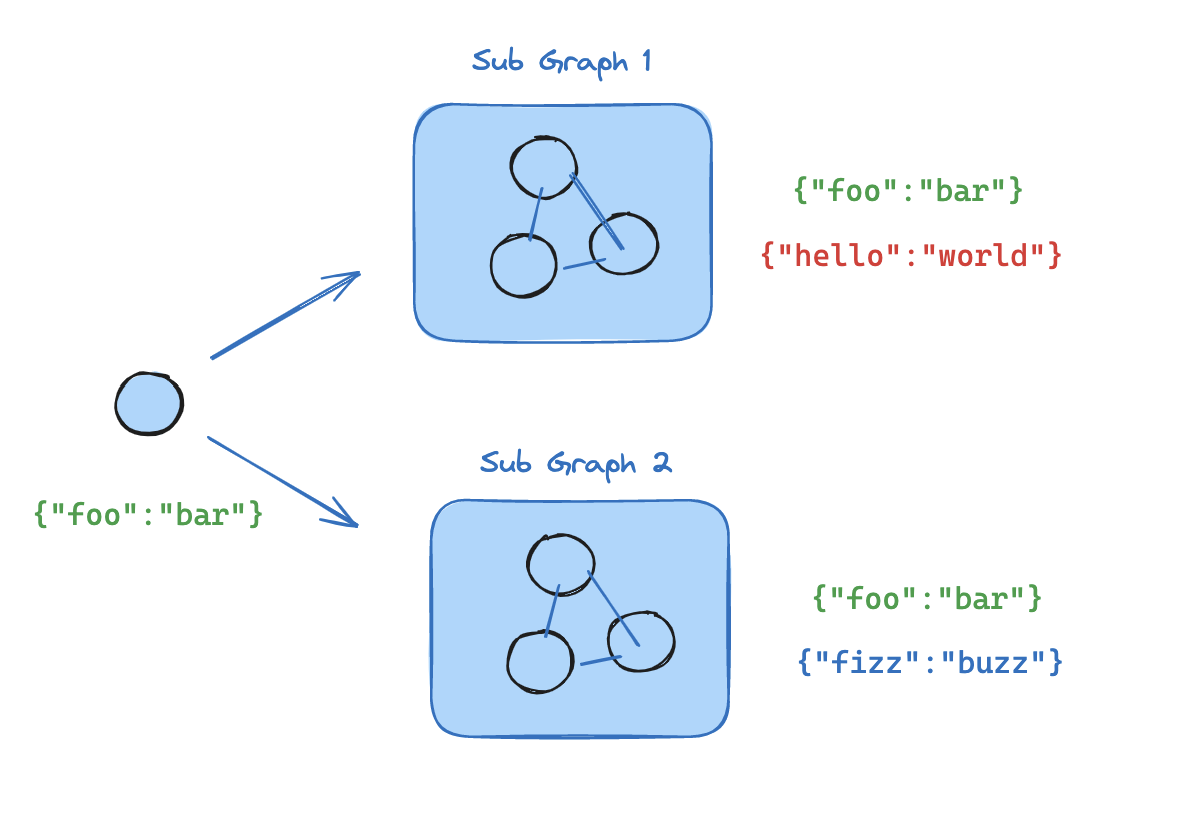

```
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

class State(TypedDict):
    foo: str

# Subgraph

def subgraph_node_1(state: State):
    return {"foo": "hi! " + state["foo"]}

subgraph_builder = StateGraph(State)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph = subgraph_builder.compile()

# Parent graph

builder = StateGraph(State)
builder.add_node("node_1", subgraph)
builder.add_edge(START, "node_1")
graph = builder.compile()

```


#🔍 Challenge #7: Observability

Problem in LangChain:

>Tracing is supported via LangSmith, but for glue code and complex logic, tracing becomes unreliable or fragmented.

LangGraph Advantage:

>Each node, state transition, and retry is fully traceable and observable using LangSmith.

#✅ Summary Table

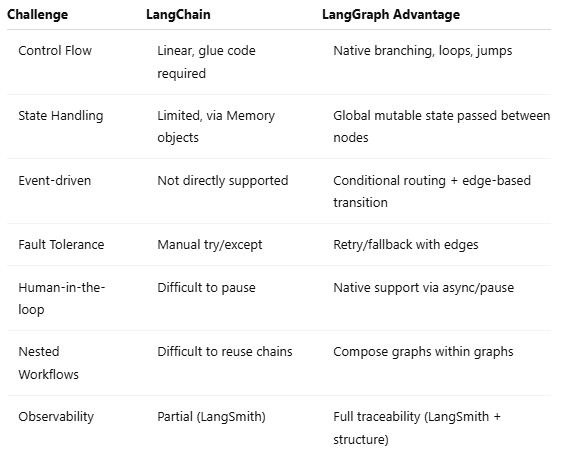

#🧹 What is LangGraph?

LangGraph is a graph-based execution framework for building stateful, composable LLM applications. It provides primitives like:

>StateGraph

>Nodes

>Conditional Edges

>Built-in support for memory, loops, and tools

LangGraph is built on top of LangChain and LangSmith but focuses on orchestrating agents in a structured way.

#📌 When to use what?

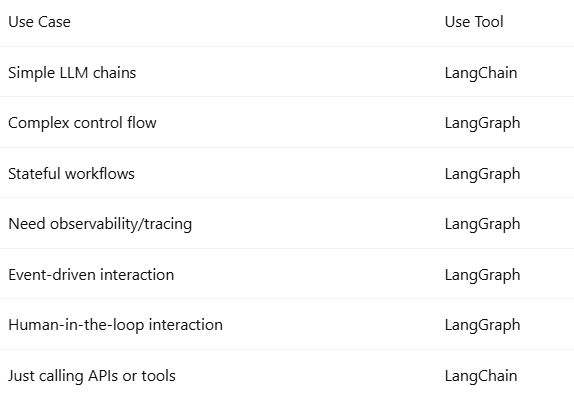

#❓ Should we still use LangChain?

Yes — LangChain is still useful for small or moderately complex tasks, such as RAG, document Q&A, summarization, and quick agent setups. LangGraph is better for workflows where state, branching, retries, and observability matter.

#🌟 Conclusion:

LangGraph is not a replacement, but a complement to LangChain. Use LangChain for building blocks, and LangGraph to orchestrate those blocks intelligently and robustly.

